In [ ]:
import pandas as pd
import numpy as np
import xgboost as xg
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense,Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

fields = ['Test_dataset', 'Classifier', 'F1', 'G-mean', 'Accuracy', 'Precision', 'Recall','ROC_AUC','PR_AUC','Balanced_Accuracy','CWA']
resamplings = ['None', 'SMOTE', 'NearMiss',
       'SMOTEENN', 'Randomoversampling', 'ADASYN', 'BorderlineSMOTE',
       'SVMSMOTE', 'RandomUnderSampler', 'ClusterCentroids',
       'NearMissversion1', 'NearMissversion2', 'NearMissversion3',
       'TomekLinks', 'EditedNearestNeighbours',
       'RepeatedEditedNearestNeighbours', 'AllKNN',
       'CondensedNearestNeighbour', 'NeighbourhoodCleaningRule',
       'InstanceHardnessThreshold', 'SMOTETomek']
df = pd.read_csv("C:/Ronald/uOttawa/CSI 6900/Metallic-main/Metafeature/features.csv")
dataset_names=list(df['Dataset'])
# names=np.unique(dataset_names)
names = ["BreastCancer"]
results_df = pd.DataFrame(columns=['Classifier', 'Dataset', 'Resamplings', 'Metric', 'Predictions', 'Actual'])
for j in ['KNN','DT','GNB','SVM','RF','GB','ADA','CAT']:
    for i in names:
        print(i)
        for metric in ['F1','G-mean','Accuracy','Precision','Recall','AUC-ROC','AUC-PR','BalancedAccuracy','CWA']:
            dataframe = df[df['Dataset'] != i]
            x_test_sample = df[df['Dataset'] == i]
            x_test_selected = x_test_sample[x_test_sample[j] == 1]
            y_test = np.array(x_test_selected[metric])
            x_test = x_test_selected.iloc[:, 1:50]
            x_test_sample=x_test.iloc[:,28:]
            count1=1
            sample_not_present=[]
            for kk in range(0,21):
                sample1=list(x_test_sample.iloc[:,kk])
                if 1 not in sample1:
                    sample_not_present.append(count1)
                count1=count1+1
            selected_dataframe = dataframe[dataframe[j] == 1]
            y_train = np.array(selected_dataframe[metric])
            x_train = selected_dataframe.iloc[:, 1:50]
            xgb = xg.XGBRegressor(objective ='reg:squarederror',colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_depth=3,
                                        min_child_weight=1.5,n_estimators=10000, reg_alpha=0.75, reg_lambda=0.45, subsample=0.6, seed=42)

            x_train = np.array(x_train)
            y_train[np.isnan(y_train)] = 0
            xgb.fit(np.array(x_train), y_train)

            y_pred_xgb = list(xgb.predict(np.array(x_test)))
            if len(y_pred_xgb) != 21:
                for ii in sample_not_present:
                    y_pred_xgb.insert(int(ii)-1,0)
            y_pred_new  = []
            for y_pred in y_pred_xgb:
                if y_pred > 1:
                    print(y_pred)
                    y_pred = y_pred - 0.09
                    print(y_pred)
                y_pred_new.append(y_pred)  
            y_pred_xgb = pd.DataFrame(y_pred_new)
            # y_pred_xgb = pd.DataFrame(y_pred_xgb)

            y_test=list(y_test)
            if len(y_test)!=21:
                for ij in sample_not_present:
                    y_test.insert(int(ij)-1,0)
            y_test=pd.DataFrame(y_test)

            temp_df = pd.DataFrame({
                    'Classifier': [j]*len(y_test),
                    'Dataset': [i]*len(y_test),
                    'Resamplings': resamplings,
                    'Metric': [metric]*len(y_test),  
                    'Predictions': y_pred_xgb.squeeze().to_list(),
                    'Actual':y_test.squeeze().to_list()
                    })
            results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df.to_csv('./result.csv')

In [54]:
results_df

,Classifier,Dataset,Resamplings,Metric,Predictions,Actual
0,KNN,BreastCancer,None,F1,0.894021,0.940238
1,KNN,BreastCancer,SMOTE,F1,0.950015,0.974130
2,KNN,BreastCancer,NearMiss,F1,0.906999,0.939651
3,KNN,BreastCancer,SMOTEENN,F1,0.931084,0.996466
4,KNN,BreastCancer,Randomoversampling,F1,0.935456,0.969750
...,...,...,...,...,...,...
1507,CAT,BreastCancer,AllKNN,CWA,0.056100,0.076090
1508,CAT,BreastCancer,CondensedNearestNeighbour,CWA,0.112414,0.057516
1509,CAT,BreastCancer,NeighbourhoodCleaningRule,CWA,0.053721,0.066212
1510,CAT,BreastCancer,InstanceHardnessThreshold,CWA,0.063957,0.109906


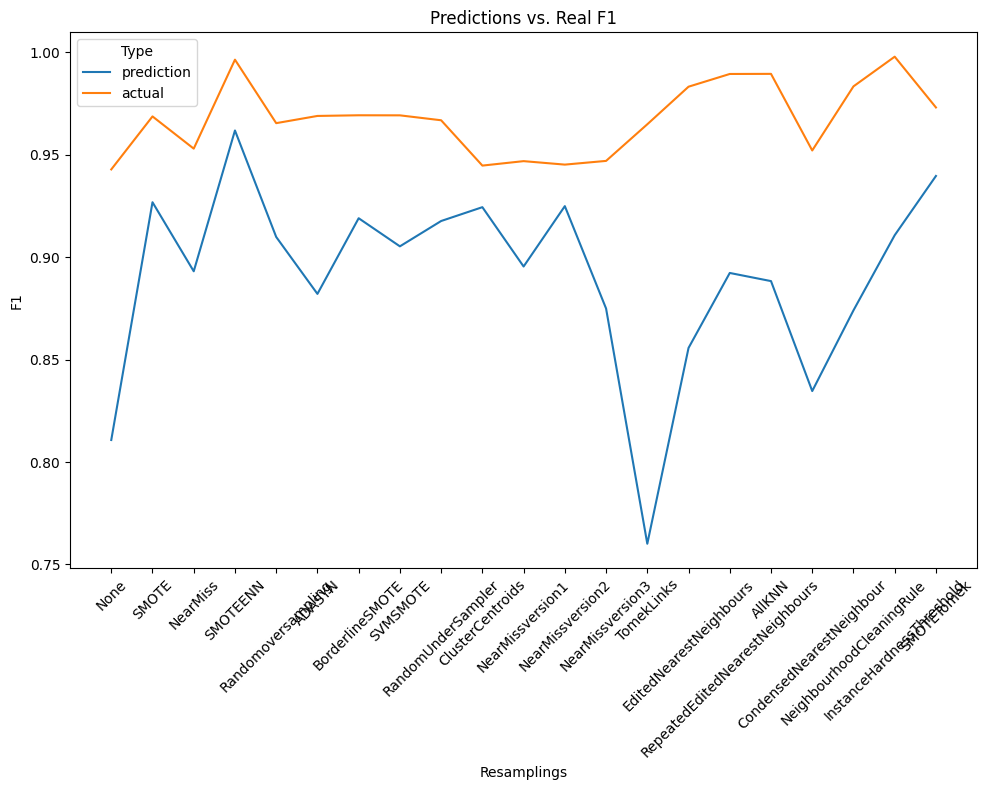

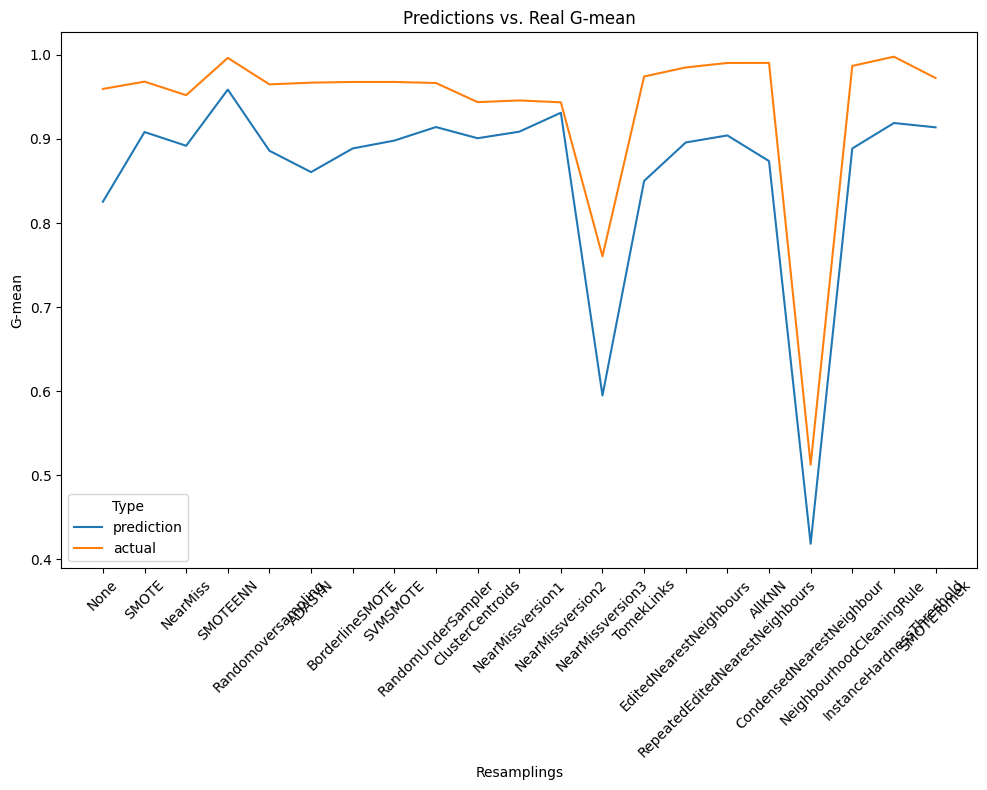

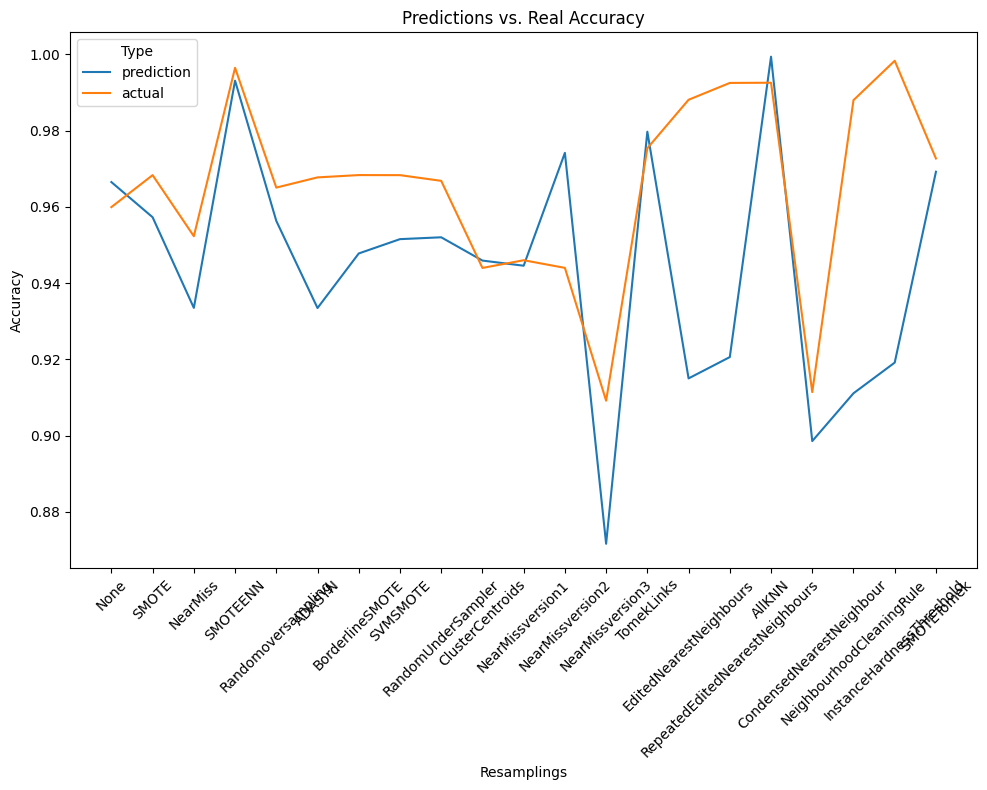

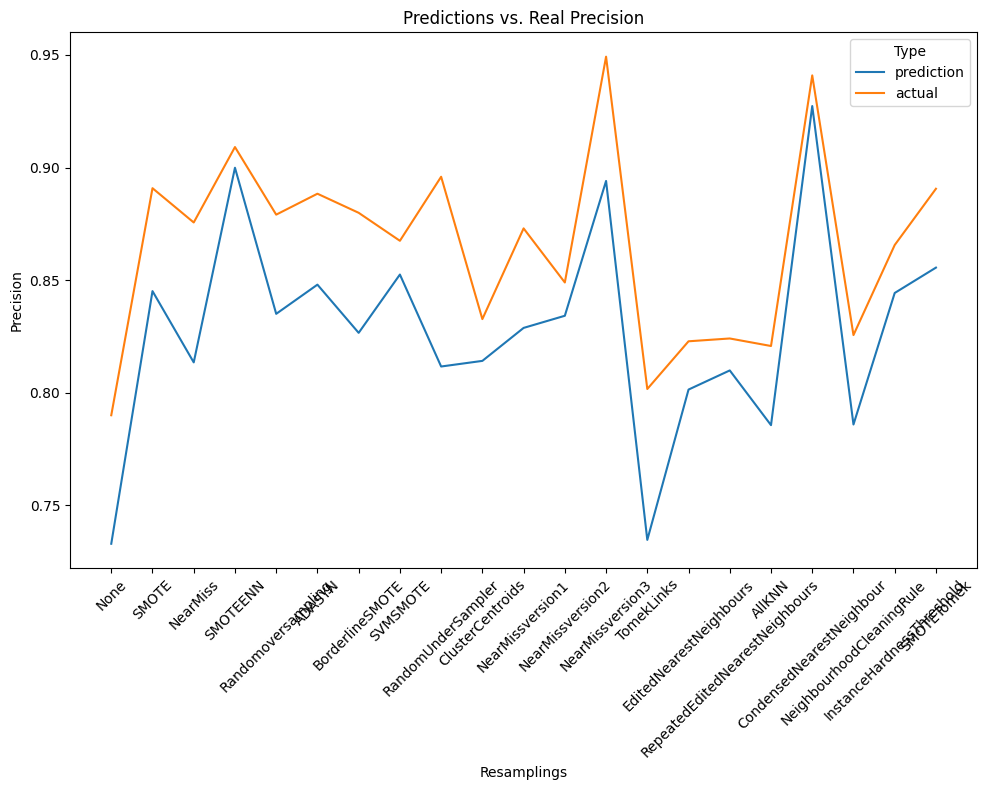

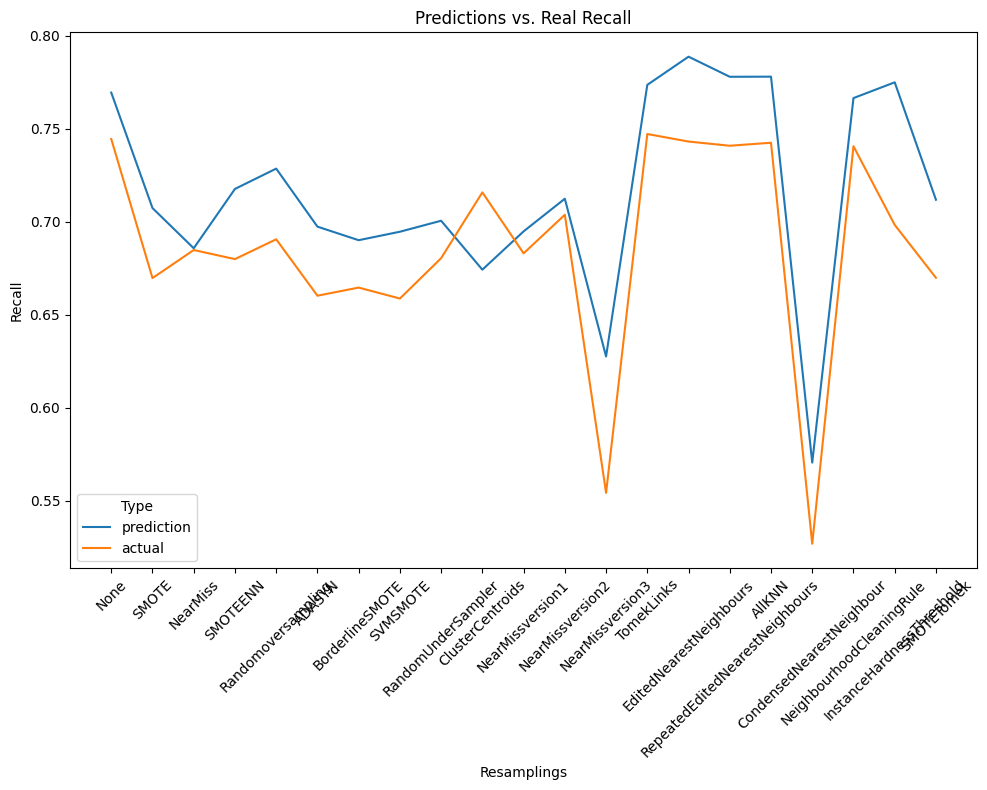

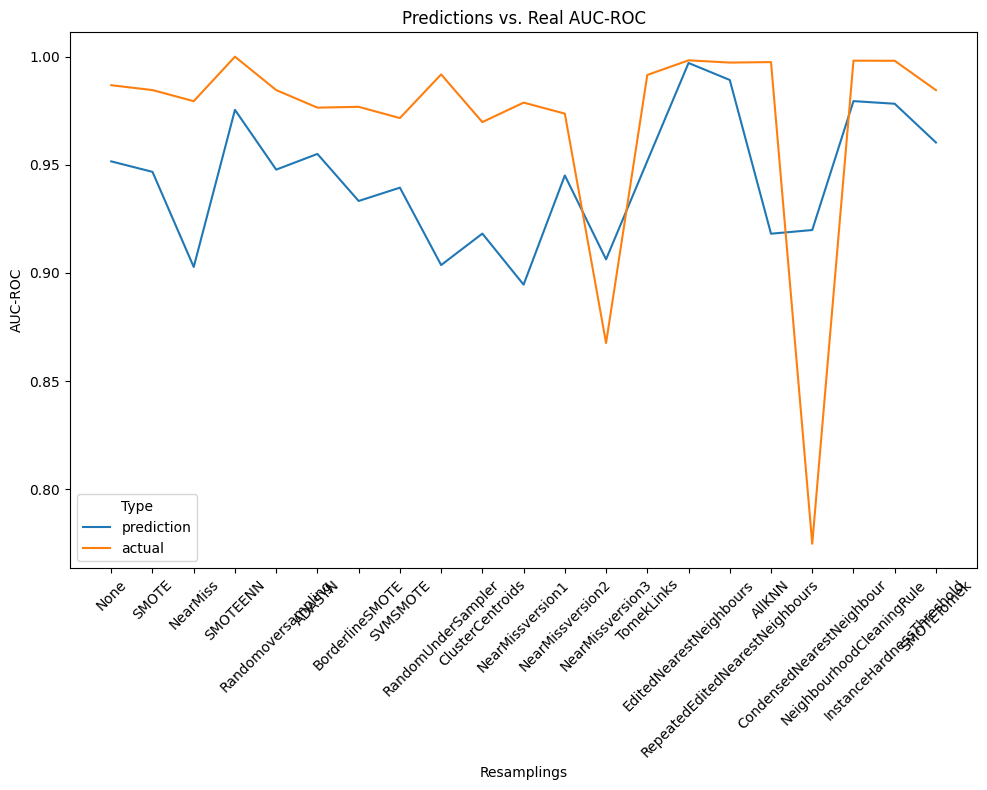

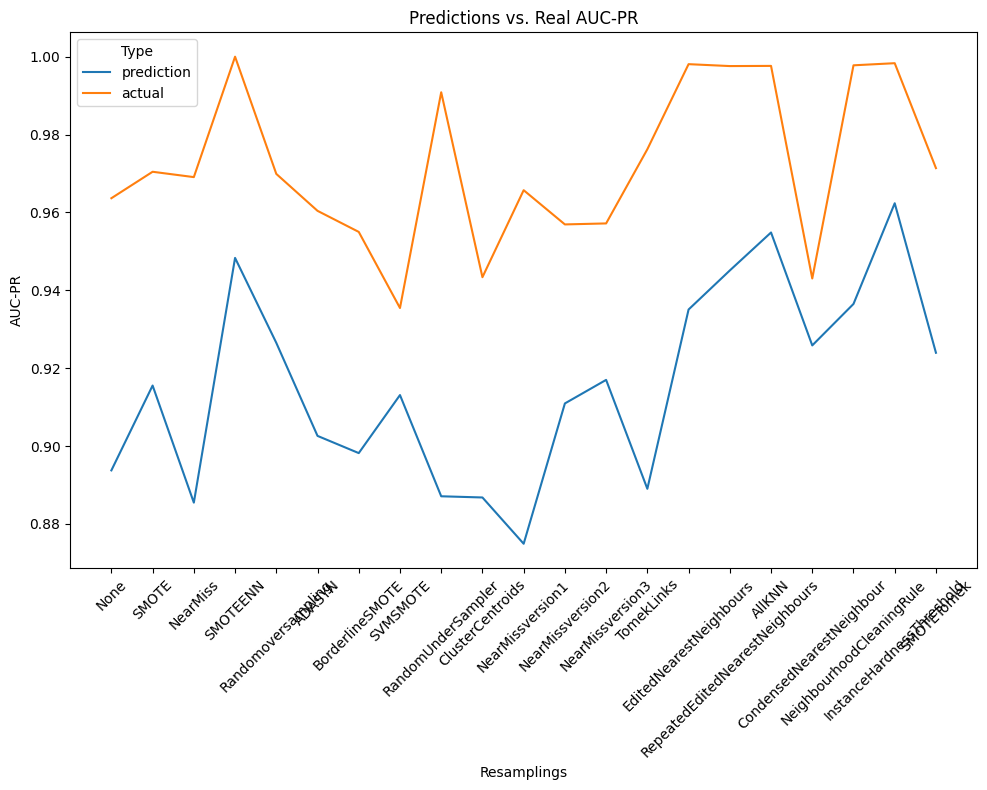

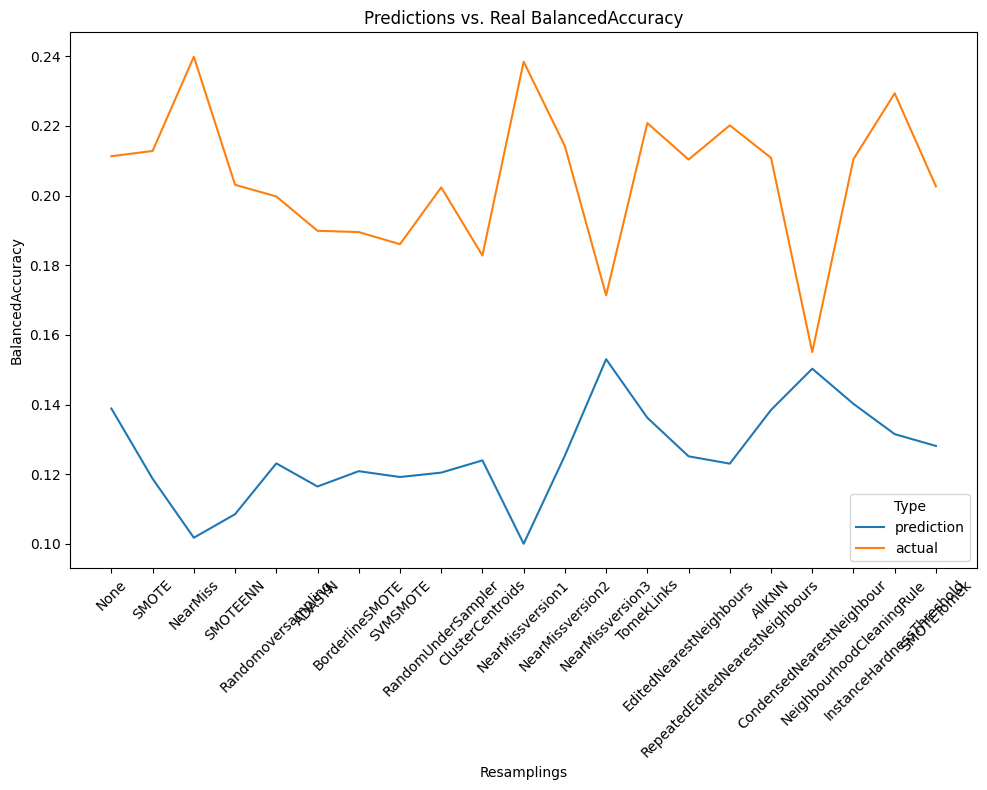

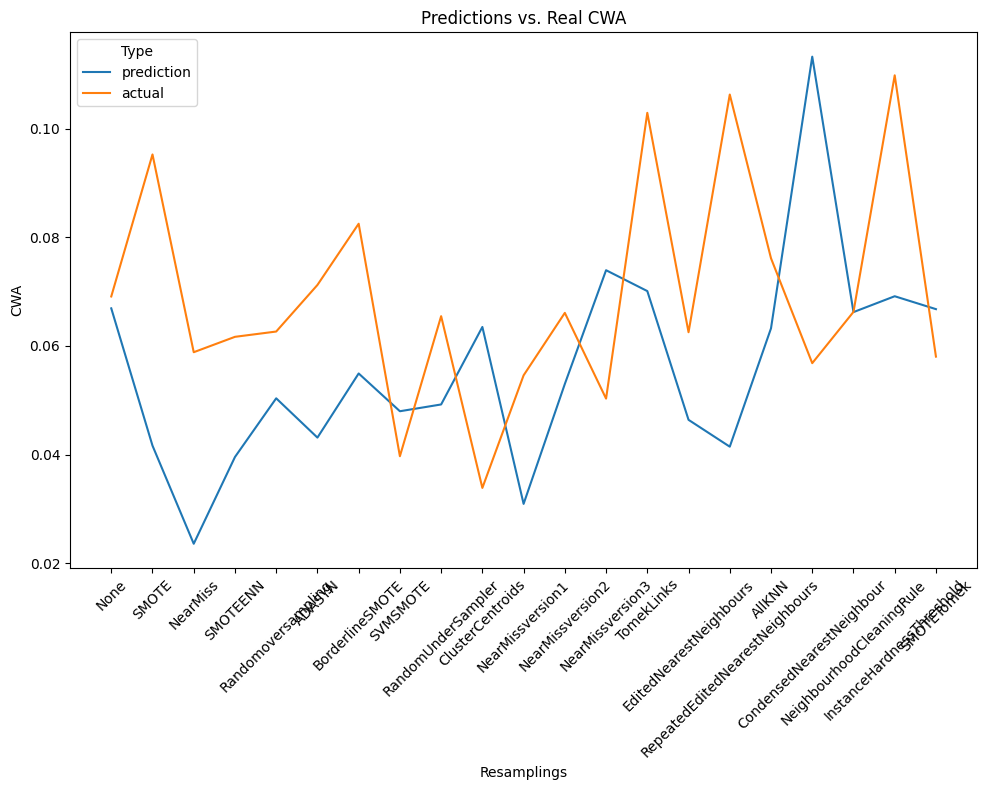

In [59]:
metrics = ['F1','G-mean','Accuracy','Precision','Recall','AUC-ROC','AUC-PR','BalancedAccuracy','CWA']
Classifier = 'SVM'
for metric in metrics:
    predictions = results_df[(results_df['Classifier'] == Classifier)&(results_df['Metric'] == metric)]['Predictions']
    actual = results_df[(results_df['Classifier'] == Classifier)&(results_df['Metric'] == metric)]['Actual']
    plt.figure(figsize=(10, 8))
    plt.plot(resamplings,predictions,label = 'prediction')
    plt.plot(resamplings,actual,label = 'actual')
    plt.title('Predictions vs. Real' + ' ' + metric)
    plt.xlabel('Resamplings')
    plt.ylabel(metric)
    plt.legend(title='Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
